# Wrapping and using a Keras model #

This notebook shows how ALIEN wraps a Keras model, computes uncertainties, covariances, and correlations, and makes batch selections. We will use a 2-dimensional input space and a simple synthetic dataset, to allows us to visualize what's going on.

In [1]:
# This gives Jupyter access to the SDK without having to install it

from pathlib import Path
import sys
sys.path.append((Path.cwd().parent).as_posix())

We define a synthetic dataset. First we define a ground truth, i.e., a target function `fn` which our model will try to learn:

In [2]:
random_seed = 12

import numpy as np
rng = np.random.default_rng(random_seed)

def fn(X, noise=True):
    return np.sin(np.pi * 4 * X[...,0]) + np.cos(np.pi * 4 * X[...,1]) + \
        noise * rng.uniform(-.1, .1, X.shape[:-1])

Let's see how this looks:

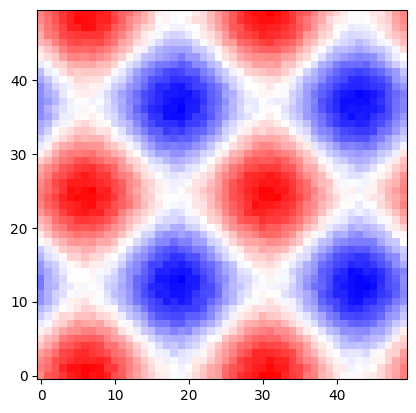

In [3]:
import matplotlib.pyplot as plt

lin = np.linspace(0,1,50)
X_test = np.stack(np.meshgrid(lin, lin), axis=2)
y_test = fn(X_test)
plt.imshow(y_test, origin='lower', cmap='bwr');

We now select a sub-region where the model will actually see training data:

In [4]:
def cut(X):
    return X[...,0]**2 + 2 * X[...,1]**2

X = rng.uniform(0, 1, size=(1000,2))
X_train = X[cut(X) < .8]
y_train = fn(X_train)

In this plot, we see the actual training set, against a backdrop of the target function. We see that there is a large "unknown region":

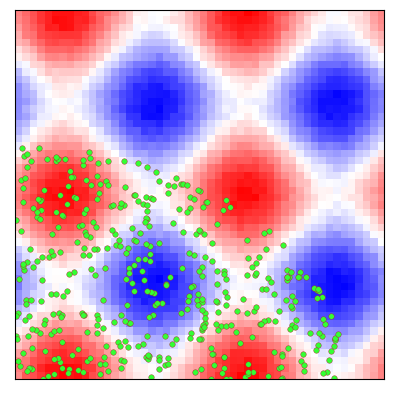

In [5]:
plt.xticks([]), plt.yticks([])
plt.imshow(y_test, origin='lower', extent=(0,1,0,1), cmap='bwr')
plt.scatter(X_train[:,0], X_train[:,1], s=16, color=(.2,1,.2), edgecolors='brown', linewidths=.3);

### The model ###

We define a simple multi-layer perceptron using the Keras API:

In [6]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

#tf.keras.utils.set_random_seed(random_seed)

keras_model = Sequential((
    #Dropout(.1),
    Dense(128, activation='gelu'),
    Dropout(.1),
    Dense(128, activation='gelu'),
    Dropout(.1),
    Dense(128, activation='gelu'),
    Dropout(.1),
    Dense(1),
))

2023-06-05 02:39:55.101798: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-05 02:39:55.148420: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-05 02:39:55.149374: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 02:39:55.907323: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


We wrap the Keras model in our `Regressor` class, which creates the tooling needed to get covariances out of the model. We pass in the training set as well.

We specify `uncertainty='dropout'`, so that the model gets covariances from the MC dropout method. Alternatively, we could use `uncertainty='laplace'`, which would get covariances using the Laplace approximation on the last layer weights

In [7]:
from alien.models import Regressor

model = Regressor(model=keras_model, X=X_train, y=y_train, uncertainty='dropout', random_seed=random_seed)

/tmp/ipykernel_22112/2062809242.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) MCDropoutRegressor. (Use `Regressor` class with uncertainty='dropout' argument.) -- Deprecated since version 1.1.
  model = MCDropoutRegressor(model=keras_model, X=X_train, y=y_train, random_seed=random_seed)


We call the model's `.fit` method. If we hadn't passed `X` and `y` during the construction of `Regressor`, we would pass it in here. This method uses Keras' training code under the hood.

In [8]:
%%capture

model.fit(epochs=400)

### Invoking the model ###

We invoke the model on our "test set" (the same 50x50 grid we use for our visualizations) to compute predictions, the covariance matrix, uncertainties (in the form of standard deviations).

In [9]:
from alien.utils import diagonal

pred = model.predict(X_test)
cov = model.covariance(X_test)
std = np.sqrt(diagonal(cov, degree=2))

Next, we show several plots.
- The first two are *ground truth*, and *prediction*, with the "trained region" highlighted. We see that in the trained region, the predictions look a lot like the ground truth.
- The next two are the *residuals* (i.e., the absolute error), and the model's assessment of its own *uncertainty* (i.e., the standard deviation of the ensemble of dropout predictions). We see that uncertainty is highest in regions where the actual error is highest.

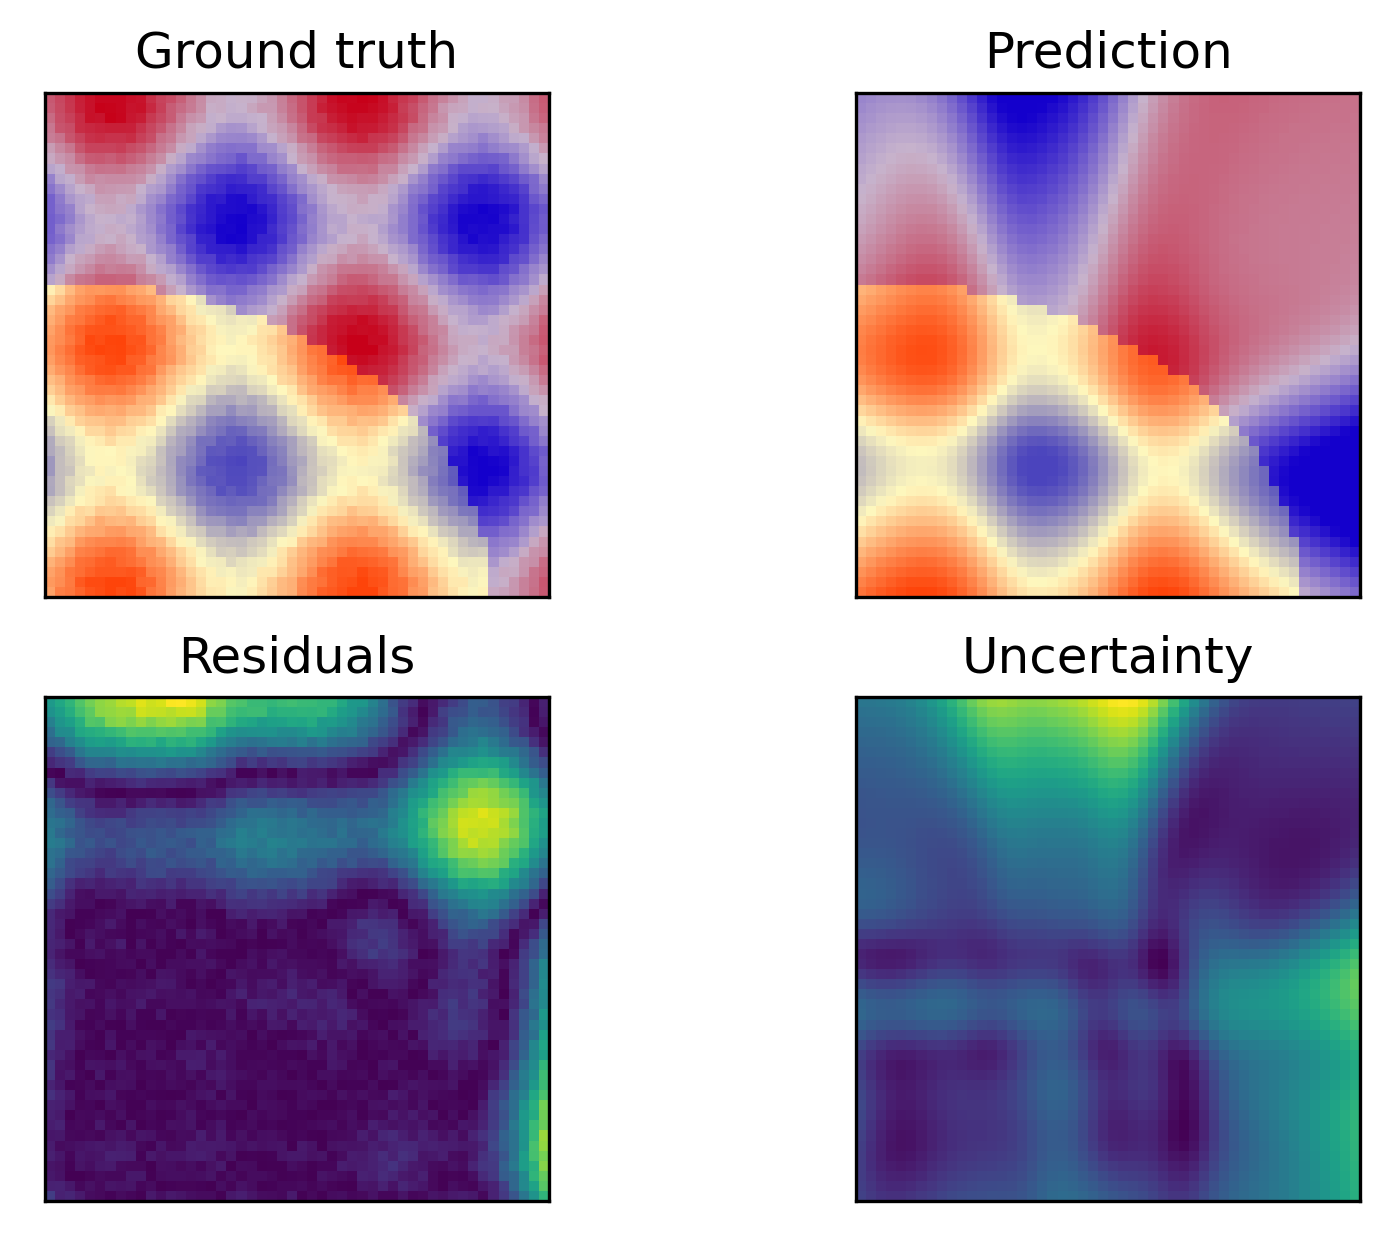

In [10]:
fig, axes = plt.subplots(2,2, dpi=300)
for i, j in [(0,0),(0,1),(1,0),(1,1)]:
    axes[i][j].set_xticks([]), axes[i][j].set_yticks([]) 

axes[0][0].set_title("Ground truth")
axes[0][0].imshow(y_test, origin='lower', cmap='bwr', vmin=-2, vmax=2);
axes[0][0].imshow(cut(X_test) < .8, origin='lower', alpha=.3)

axes[0][1].set_title("Prediction")
axes[0][1].imshow(np.asarray(pred).reshape(50,50), origin='lower', cmap='bwr', vmin=-2, vmax=2);
axes[0][1].imshow(cut(X_test) < .8, origin='lower', alpha=.3)

axes[1][0].set_title("Residuals")
axes[1][0].imshow(np.abs(np.asarray(pred).reshape(50,50) - y_test), origin='lower', cmap='viridis')#, vmin=-2, vmax=2);

axes[1][1].set_title("Uncertainty")
axes[1][1].imshow(std.reshape(50,50), origin='lower', cmap='viridis');

### Covariance ###

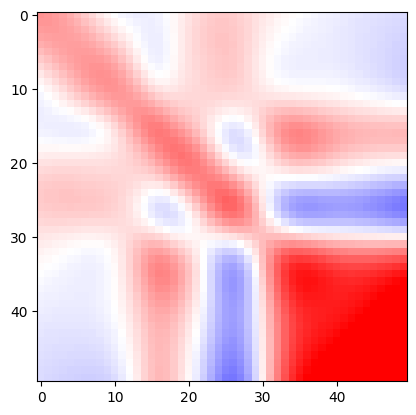

In [11]:
plt.imshow(cov[25,:,25,:], cmap='bwr', vmin=-.05, vmax=.05)

## Correlations ##

In [12]:
from alien.decorators import flatten_batch
from alien.utils import reshape

imsize = 50
# Correlation from covariance:
#flatten_batch(bdim=-1, degree=2)
def cor_from_cov(cov):
    cov = reshape(cov, (imsize**2, imsize**2))
    std = 1 / np.sqrt(np.diag(cov))
    return (std[:,None] * cov * std[None,:]).reshape(imsize, imsize, imsize, imsize)

Let's visualize the correlations. We will consider one at a time an "base point" and plot its correlation coefficient with every other point in the feature space. We do this for four different base points (highlighted in white in the plots).

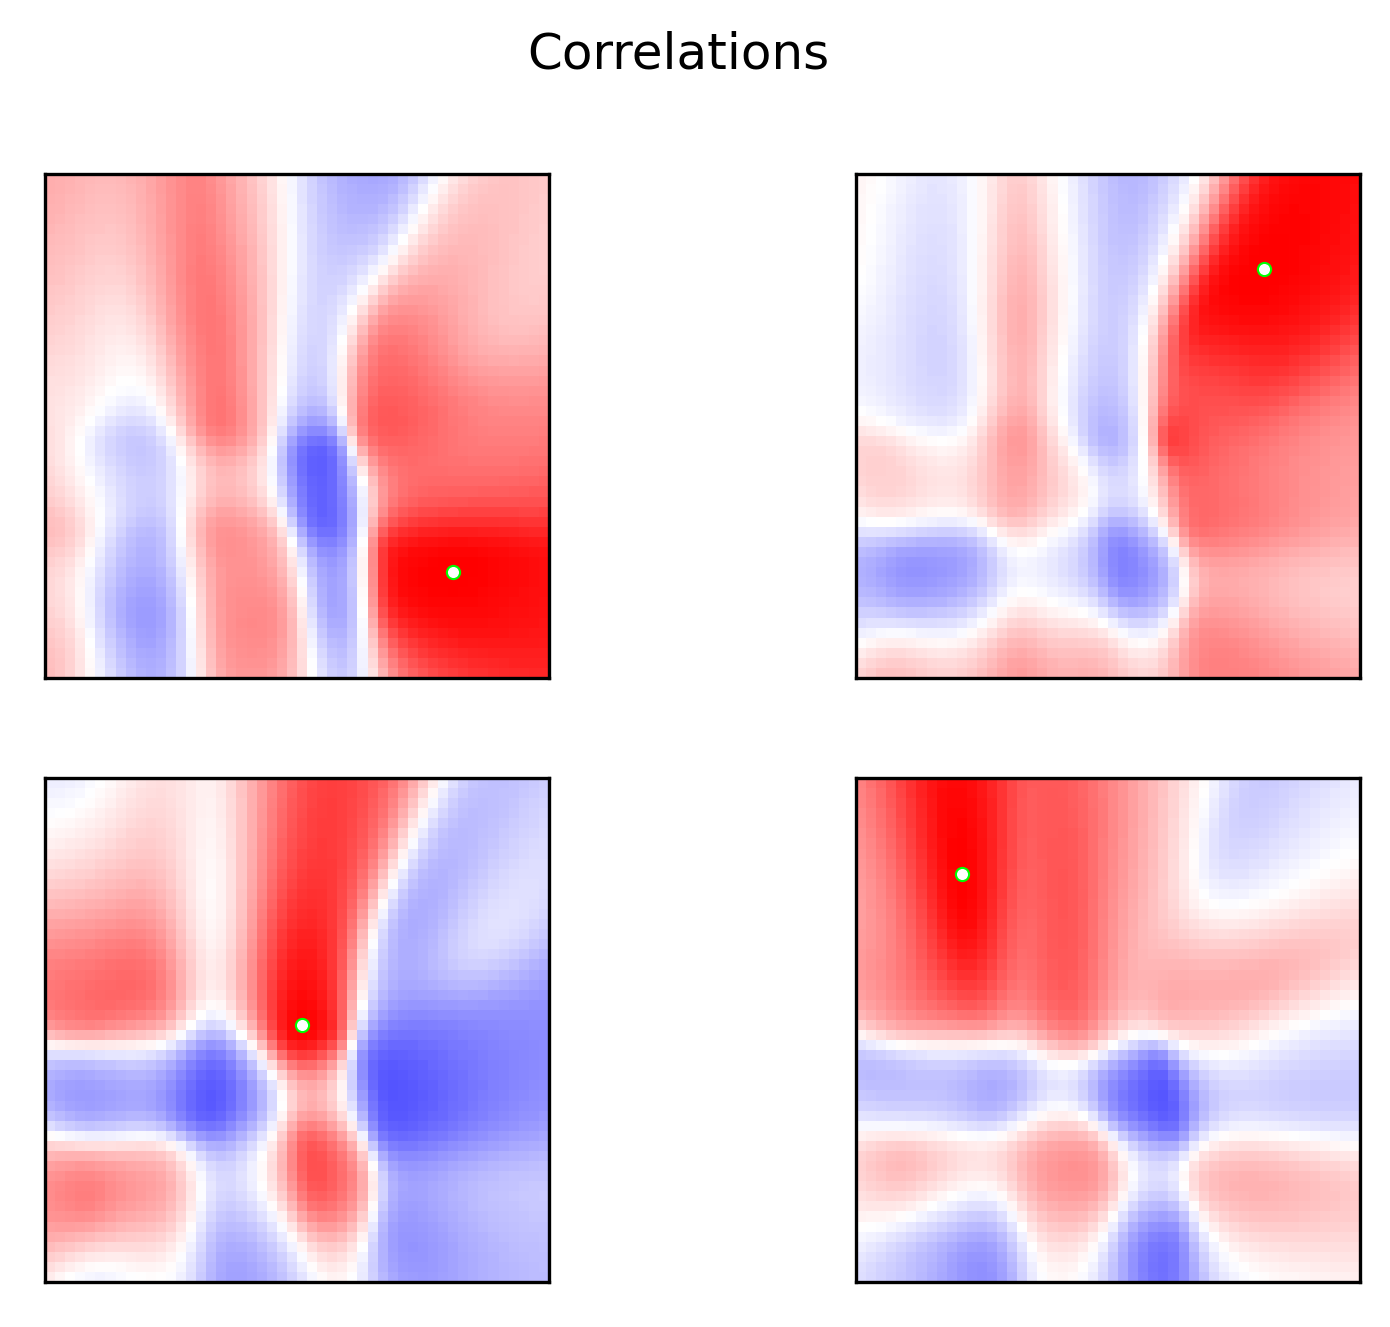

In [13]:
fig, axes = plt.subplots(2,2, dpi=300)
fig.suptitle("Correlations")

cor = cor_from_cov(cov)
pts = [(40,10), (40,40), (25,25), (10,40)]
    
for i, pt in enumerate(pts):
    ax = axes[int(i/2)][i%2]
    ax.set_xticks([]), ax.set_yticks([]) 
    
    pt_cor = cor[pt[1],pt[0]]#section(cor, *pt)
    ax.imshow(pt_cor, cmap='bwr', vmin=-1, vmax=1, origin='lower');
    ax.scatter([pt[0]], [pt[1]], s=10, c='white', edgecolor=(0,1,0), linewidth=.5)

In each case, the anchor point is most strongly correlated with points nearest to it. Notice that the correlations exhibit a quasi-periodic structure which mirrors the periodic structure of the dataset.

## Selector objects and batch selection ##
Now we build a selector object using the "max covariance" strategy (known as "COVDROP" when paired with MC dropout). `samples` and `batch_size` may instead be passed into the `.select` method later on.

In [14]:
from alien.selection import CovarianceSelector

selector = CovarianceSelector(
    model = model,
    samples = X_test.reshape((-1, 2)),
    batch_size = 10,
    random_seed = random_seed,
)

It's now a simple matter to select a batch:

In [15]:
batch = selector.select()#return_indices=True)

We show the selected points in the feature space (white dots with red outlines). Background color shows model uncertainty.

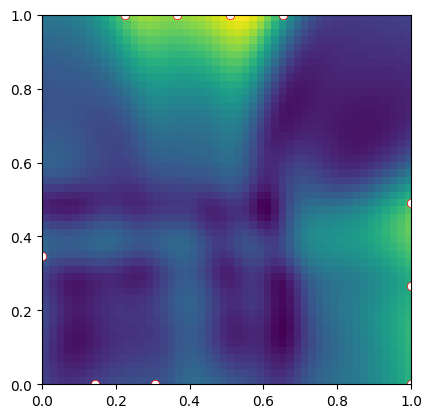

In [16]:
plt.imshow(std.reshape(50,50), origin='lower', extent=(0,1,0,1))# cmap='bwr', vmin=-2, vmax=2);
plt.scatter(batch[:,0], batch[:,1], c='white', edgecolors='red', linewidths=.5);

The selected points tend to be in areas of high uncertainty. COVDROP avoids selecting points which are too correlated with each other, which in practice means the selected points are not too close together.

We add the selected points to our training set, and retrain the model:

In [17]:
%%capture

X_train_1 = np.concatenate((X_train,batch))
y_train_1 = fn(X_train_1)

model.fit(X_train_1, y_train_1, epochs=400)

Let's see how the new data have improved the model. We show the ground truth, along with "Pred before", the predictions from the original model, and "Pred after", the predictions after training on the new data. We see some improvement.

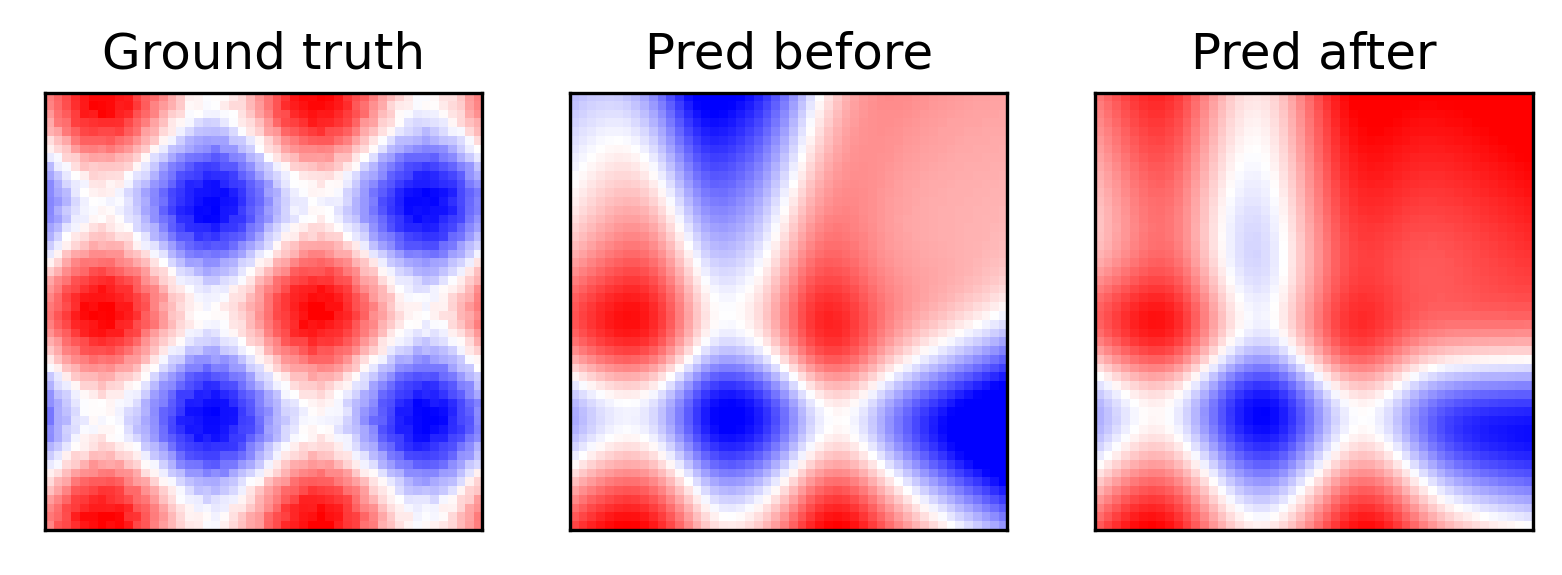

In [18]:
fig, axes = plt.subplots(1,3, dpi=300)

titles = ["Ground truth", "Pred before", "Pred after"]
images = [y_test, np.asarray(pred).reshape(50,50), model.predict(X_test)]

for ax, t, im in zip(axes, titles, images):
    ax.set_title(t)
    ax.set_xticks([]), ax.set_yticks([])
    ax.imshow(im, origin='lower', cmap='bwr', vmin=-2, vmax=2);